In [49]:
import os
import findspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import col, lit, concat_ws, collect_set, from_unixtime, udf, array, sum, count, avg
from pyspark.sql.types import TimestampType, StructField, StringType, IntegerType, StructType, DoubleType
from pyspark.sql.functions import date_format, col
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import holidays
from pyspark.ml.linalg import Vectors, VectorUDT

In [50]:
# Obtener la ruta de la carpeta del notebook
notebook_folder = os.getcwd()
root_project = os.path.abspath(os.path.join(notebook_folder, '..'))
dataset_logs = os.path.abspath(os.path.join(root_project, 'Datos', 'Logs'))
trufi_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Registros de Trufi App'))
municipios_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Poligonos de Cochabamba','region_cochabamba_2018.geojson'))
lagos_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Poligonos de Cochabamba','region_cochabamba_2018.geojson'))
clima_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Datos del clima','weather.csv'))
lagos_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Poligonos de Cochabamba','lagos.shx'))
h3_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Registros de Trufi App','id_index_h3.csv'))
map_cochabamba_file_path =  os.path.abspath(os.path.join(root_project, 'Datos', 'mapas','h3_map_cochabamba_.html'))
temporal_serie_data = os.path.abspath(os.path.join(root_project, 'Datos', 'Registros de Trufi App','temporal_serie_data'))
csv_file_path = os.path.join(trufi_datos, 'origen-destino.csv')

In [51]:
findspark.init()
findspark.find()
sc = SparkContext.getOrCreate()
# Primera sesión de Spark
spark = SparkSession.builder \
    .appName("Trufi") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.driver.host", "localhost") \
    .config("spark.master", "local") \
    .getOrCreate()

# Configurar el número de particiones
spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.sparkContext

<SparkContext master=local[*] appName=pyspark-shell>

In [52]:
# Lee el archivo CSV en un DataFrame
df = spark.read.csv("file:///" + temporal_serie_data, header=True, inferSchema=True)

# Muestra el esquema del DataFrame
df.printSchema()


root
 |-- UniqueColumn_G: string (nullable = true)
 |-- hourly_timestamp: timestamp (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- destination_request_count: integer (nullable = true)
 |-- origin_request_count: integer (nullable = true)
 |-- anio: integer (nullable = true)
 |-- mes: integer (nullable = true)
 |-- dia_de_mes: integer (nullable = true)
 |-- hora: integer (nullable = true)
 |-- dia_de_semana: integer (nullable = true)
 |-- fin_de_semana: integer (nullable = true)



In [53]:
# Lee el archivo CSV en un DataFrame de Spark
df_spark_result = spark.read.csv(clima_datos, header=True, inferSchema=True)

# Selecciona solo las columnas necesarias del DataFrame de Spark resultante
df_spark_selected = df_spark_result.select(
    'datetime',
    'temp',
    'humidity',
    'precip',
    'cloudcover',
    'windspeed'
)

# Renombra la columna 'hourly_timestamp' a 'datetime'
df_spark_selected = df_spark_selected.withColumnRenamed('hourly_timestamp', 'datetime')

# Muestra el esquema y las primeras filas del DataFrame de Spark resultante con las columnas seleccionadas
df_spark_selected.printSchema()
df_spark_selected.count()

root
 |-- datetime: timestamp (nullable = true)
 |-- temp: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- cloudcover: double (nullable = true)
 |-- windspeed: double (nullable = true)



11424

In [54]:
# Define la fecha límite
fecha_limite = '2023-12-27'

# Filtra el DataFrame de Spark

df_spark_result_filtered = df_spark_selected.filter(col('datetime') <= fecha_limite)
df_spark_result_filtered.show()

+-------------------+----+--------+------+----------+---------+
|           datetime|temp|humidity|precip|cloudcover|windspeed|
+-------------------+----+--------+------+----------+---------+
|2022-09-08 00:00:00|13.0|   47.19|   0.0|       0.0|      0.0|
|2022-09-08 01:00:00|12.0|    46.9|   0.0|       0.0|      5.4|
|2022-09-08 02:00:00|12.2|   49.17|   0.0|       5.0|      7.6|
|2022-09-08 03:00:00|10.0|   53.56|   0.0|       0.0|      0.0|
|2022-09-08 04:00:00|10.0|   53.56|   0.0|       0.0|      0.0|
|2022-09-08 05:00:00| 8.2|   60.89|   0.0|      28.1|      0.0|
|2022-09-08 06:00:00| 7.0|   65.63|   0.0|       0.0|      0.0|
|2022-09-08 07:00:00| 8.0|    61.3|   0.0|       0.0|      0.0|
|2022-09-08 08:00:00|13.7|   39.07|   0.0|       5.0|      0.0|
|2022-09-08 09:00:00|18.0|   31.88|   0.0|       0.0|      0.0|
|2022-09-08 10:00:00|22.0|   24.89|   0.0|       0.0|      0.0|
|2022-09-08 11:00:00|24.8|   21.25|   0.0|      13.1|      5.4|
|2022-09-08 12:00:00|26.0|   14.61|   0.

In [55]:
# Crea la tabla temporal para df_spark_result_filtered
df_spark_result_filtered.createOrReplaceTempView("df_spark_result_filtered")

# Clona el DataFrame df
df_clone = df.select(*df.columns)

# Realiza la fusión (merge) utilizando PySpark
df_final = df_clone.join(
    df_spark_result_filtered,
    df_clone["hourly_timestamp"] == df_spark_result_filtered["datetime"],
    how="left"
)

# Muestra el DataFrame resultante
df_final.show(100)
df_final.count()

+-------------------+-------------------+----------+-------------------------+--------------------+----+---+----------+----+-------------+-------------+-------------------+----+--------+------+----------+---------+
|     UniqueColumn_G|   hourly_timestamp|LocationID|destination_request_count|origin_request_count|anio|mes|dia_de_mes|hora|dia_de_semana|fin_de_semana|           datetime|temp|humidity|precip|cloudcover|windspeed|
+-------------------+-------------------+----------+-------------------------+--------------------+----+---+----------+----+-------------+-------------+-------------------+----+--------+------+----------+---------+
|2023-05-02 08:00_92|2023-05-02 08:00:00|        92|                        0|                   0|2023|  5|         2|   8|            3|            0|2023-05-02 08:00:00|14.9|   66.88|   0.0|      27.5|      5.4|
|2023-05-02 09:00_92|2023-05-02 09:00:00|        92|                        0|                   0|2023|  5|         2|   9|            3|  

1382016

In [57]:
# Crear un objeto para Bolivia
bo_holidays = holidays.country_holidays('BO', subdiv='C', years=[2022, 2023])

# Obtener los feriados para 2022 y 2023
holidays_list = [(date, name) for date, name in sorted(bo_holidays.items())]

# Crear un DataFrame con la lista de feriados
holidays_df = pd.DataFrame(holidays_list, columns=["date", "holiday"])
# Creating new column contain 1 for the holiday
holidays_df['Holiday_n']=1
# Muestra los primeros registros del DataFrame
print(holidays_df.head())

# Crear DataFrames de Spark desde los DataFrames de Pandas
holidays_df_spark = spark.createDataFrame(holidays_df)

# Realizar la unión utilizando Spark SQL
df_final.createOrReplaceTempView("df_final")
holidays_df_spark.createOrReplaceTempView("holidays_df_spark")

query = """
    SELECT *
    FROM df_final t
    LEFT JOIN holidays_df_spark h
    ON t.datetime = h.date
"""
df_final_merged_spark = spark.sql(query)
df_final_merged_spark = df_final_merged_spark.drop("date").drop("holiday")

# Reemplazar los valores nulos en la columna 'Holiday_n' con 0
df_final_merged_spark = df_final_merged_spark.fillna(0, subset=["Holiday_n"])

# Muestra el DataFrame resultante
df_final_merged_spark.count()

         date                                            holiday  Holiday_n
0  2022-01-01                                          Año Nuevo          1
1  2022-01-22  Día de la Creación del Estado Plurinacional de...          1
2  2022-02-28                                           Carnaval          1
3  2022-03-01                                           Carnaval          1
4  2022-04-15                                      Viernes Santo          1


1382016

In [58]:
df_final_merged_spark.describe()

DataFrame[summary: string, UniqueColumn_G: string, LocationID: string, destination_request_count: string, origin_request_count: string, anio: string, mes: string, dia_de_mes: string, hora: string, dia_de_semana: string, fin_de_semana: string, temp: string, humidity: string, precip: string, cloudcover: string, windspeed: string, Holiday_n: string]

In [59]:
# Seleccionar las columnas relevantes para el análisis de correlación
selected_columns = ["hourly_timestamp","origin_request_count", "LocationID", "destination_request_count", "Holiday_n", "windspeed", "cloudcover", "precip", "humidity", "temp", "fin_de_semana","dia_de_semana","hora","dia_de_mes","mes","anio"]  # Agrega tus columnas aquí

# Crear un DataFrame de Spark solo con las columnas seleccionadas
selected_data = df_final_merged_spark.select(selected_columns)

# Definir una función UDF para convertir las columnas en un vector
vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Aplicar la conversión manualmente a las columnas seleccionadas
for col_name in selected_columns:
    selected_data = selected_data.withColumn(col_name, col(col_name).cast(DoubleType()))

selected_data.show()

+----------------+--------------------+----------+-------------------------+---------+---------+----------+------+--------+----+-------------+-------------+----+----------+---+------+
|hourly_timestamp|origin_request_count|LocationID|destination_request_count|Holiday_n|windspeed|cloudcover|precip|humidity|temp|fin_de_semana|dia_de_semana|hora|dia_de_mes|mes|  anio|
+----------------+--------------------+----------+-------------------------+---------+---------+----------+------+--------+----+-------------+-------------+----+----------+---+------+
|     1.6830288E9|                 0.0|      92.0|                      0.0|      0.0|      5.4|      27.5|   0.0|   66.88|14.9|          0.0|          3.0| 8.0|       2.0|5.0|2023.0|
|     1.6830324E9|                 0.0|      92.0|                      0.0|      0.0|      5.4|      27.5|   0.0|   52.28|19.0|          0.0|          3.0| 9.0|       2.0|5.0|2023.0|
|      1.683036E9|                 0.0|      92.0|                      0.0|    

In [60]:
selected_data_p = selected_data.toPandas()
# Filtra las filas que contienen al menos un valor NaN en cualquier columna
condition = selected_data_p["temp"].isna() | selected_data_p["precip"].isna() | selected_data_p["humidity"].isna() | selected_data_p["cloudcover"].isna()
df_final_with_nan = selected_data_p[condition]

# Muestra el DataFrame resultante
df_final_with_nan
len(df_final_with_nan)

0

<Axes: >

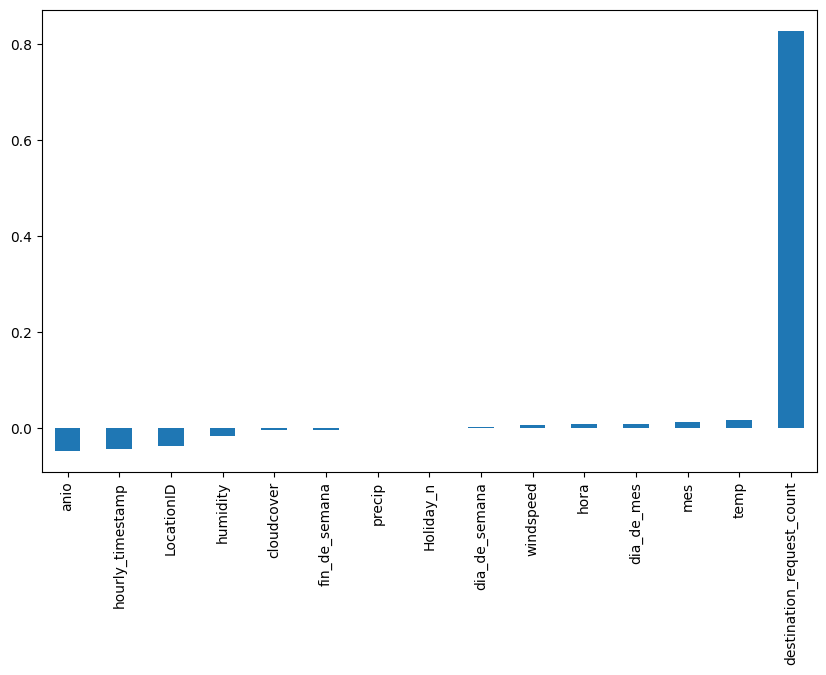

In [61]:
selected_data_p.corr()['origin_request_count'].sort_values().drop('origin_request_count').plot(kind='bar',figsize=(10,6))

<Axes: >

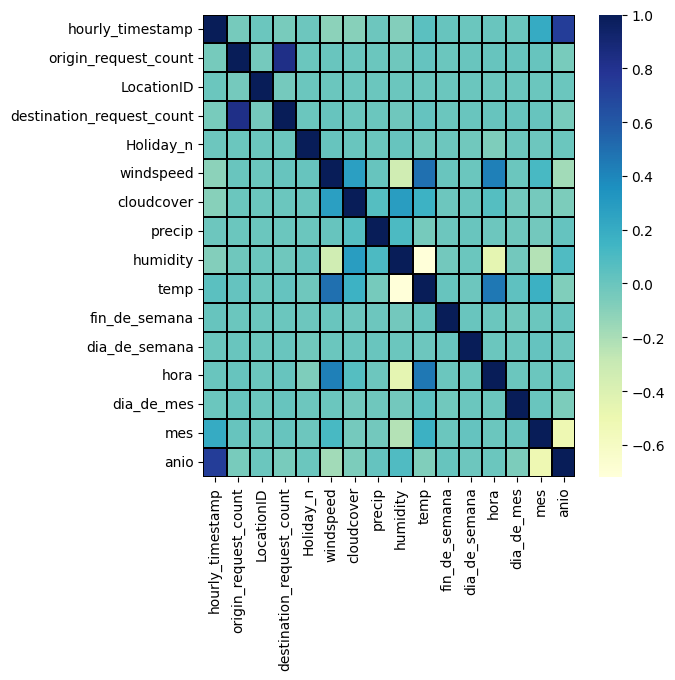

In [62]:

plt.figure(figsize=(6, 6))

sns.heatmap(selected_data_p.corr(), linewidth=0.3, linecolor='black', cmap="YlGnBu")

In [63]:
# Lee el archivo de H3 en un DataFrame de PySpark
h3_df = spark.read.csv(h3_datos, header=True, inferSchema=True)
# Convierte el DataFrame de Pandas a un DataFrame de PySpark
selected_data_spark = spark.createDataFrame(selected_data_p)
# Convierte la columna 'hourly_timestamp' a tipo fecha
selected_data_spark = selected_data_spark.withColumn('hourly_timestamp', from_unixtime('hourly_timestamp').cast(TimestampType()))

# Realiza la unión utilizando la condición de igualdad en las columnas
df_final = selected_data_spark.join(h3_df, col("LocationID") == col("id"), "left")
df_final.show(20)

+-------------------+--------------------+----------+-------------------------+---------+---------+----------+------+--------+----+-------------+-------------+----+----------+---+------+---------------+---+-------------------+------------------+
|   hourly_timestamp|origin_request_count|LocationID|destination_request_count|Holiday_n|windspeed|cloudcover|precip|humidity|temp|fin_de_semana|dia_de_semana|hora|dia_de_mes|mes|  anio|       h3_index| id|           latitude|         longitude|
+-------------------+--------------------+----------+-------------------------+---------+---------+----------+------+--------+----+-------------+-------------+----+----------+---+------+---------------+---+-------------------+------------------+
|2023-05-02 08:00:00|                 0.0|      92.0|                      0.0|      0.0|      5.4|      27.5|   0.0|   66.88|14.9|          0.0|          3.0| 8.0|       2.0|5.0|2023.0|878b2c8b5ffffff| 92|-17.410627545019018|-66.11078732971455|
|2023-05-02 09:0

In [64]:
df_final.count()
# Muestra los últimos elementos (por ejemplo, los últimos 10)
df_final.orderBy(col("hourly_timestamp").desc()).show(10)

+-------------------+--------------------+----------+-------------------------+---------+---------+----------+------+--------+----+-------------+-------------+----+----------+----+------+---------------+---+-------------------+------------------+
|   hourly_timestamp|origin_request_count|LocationID|destination_request_count|Holiday_n|windspeed|cloudcover|precip|humidity|temp|fin_de_semana|dia_de_semana|hora|dia_de_mes| mes|  anio|       h3_index| id|           latitude|         longitude|
+-------------------+--------------------+----------+-------------------------+---------+---------+----------+------+--------+----+-------------+-------------+----+----------+----+------+---------------+---+-------------------+------------------+
|2023-12-26 23:00:00|                 0.0|      69.0|                      0.0|      0.0|      1.8|      96.7|   0.0|   47.06|17.3|          0.0|          3.0|23.0|      26.0|12.0|2023.0|878b2cd41ffffff| 69|-17.424220265810987|-66.01286929233731|
|2023-12-26 

In [67]:
# Especifica la ruta del archivo CSV en el sistema de archivos local
csv_local_path = "file:///" + temporal_serie_data
df_final.write.mode("overwrite").option("header", "true").csv(csv_local_path)


Py4JJavaError: An error occurred while calling o996.csv.
: java.util.NoSuchElementException: None.get
	at scala.None$.get(Option.scala:529)
	at scala.None$.get(Option.scala:527)
	at org.apache.spark.sql.execution.datasources.BasicWriteJobStatsTracker$.metrics(BasicWriteStatsTracker.scala:239)
	at org.apache.spark.sql.execution.command.DataWritingCommand.metrics(DataWritingCommand.scala:55)
	at org.apache.spark.sql.execution.command.DataWritingCommand.metrics$(DataWritingCommand.scala:55)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.metrics$lzycompute(InsertIntoHadoopFsRelationCommand.scala:47)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.metrics(InsertIntoHadoopFsRelationCommand.scala:47)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.metrics$lzycompute(commands.scala:109)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.metrics(commands.scala:109)
	at org.apache.spark.sql.execution.SparkPlanInfo$.fromSparkPlan(SparkPlanInfo.scala:63)
	at org.apache.spark.sql.execution.SparkPlanInfo$.$anonfun$fromSparkPlan$3(SparkPlanInfo.scala:75)
	at scala.collection.immutable.List.map(List.scala:293)
	at org.apache.spark.sql.execution.SparkPlanInfo$.fromSparkPlan(SparkPlanInfo.scala:75)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:115)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:104)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:488)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:133)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:856)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:387)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:360)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:847)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)


In [66]:
spark.stop()